
# Setting up the project

In [1]:
%reload_ext autoreload
%autoreload 2
!pip install tensorflow[and-cuda]
!pip install transformers
!pip install ipywidgets
!pip install bertviz
!pip install sentence_transformers


# # check if the gpus are indeed available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

zsh:1: no matches found: tensorflow[and-cuda]
^C
ERROR: Operation cancelled by user


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import os
from google.colab import drive

drive.mount("/content/j-drive", force_remount=True)
os.chdir("/content/j-drive/MyDrive/ir-project")

## Handling the imports

In [3]:
# imports and the model used

import loader as ld
from loadtrials import load_trials, load_queries, get_evaluator, LONG_QUERIES
from transformers import *
import numpy as np
import pprint as pp
import torch
import pandas as pd
import matplotlib.pyplot as plt

# ..
# MODEL_PATH = 'dmis-lab/biobert-v1.1'
MODEL_PATH = 'cross-encoder/qnli-electra-base'


/Users/jhertz/anaconda3/envs/ir-project/lib/python3.10/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/Users/jhertz/anaconda3/envs/ir-project/lib/python3.10/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/Users/jhertz/anaconda3/envs/ir-project/lib/python3.10/site-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


## Loading the queries and documents

In [4]:
queries = load_queries(LONG_QUERIES)
eval    = get_evaluator(queries)
ids, full_docs = ld.load(
    'docs',
    lambda: load_trials(eval)
)

full_docs[0].show()

docs_desc = dict(
    [(doc._nct_id, doc._detailed_description) for doc in full_docs]
)

{
    "_nct_id": "NCT00000369",
    "_intervention": {
        "intervention_type": "Drug",
        "intervention_name": "Lithium carbonate"
    },
    "_mesh_terms": [
        "Bipolar Disorder",
        "Antidepressive Agents",
        "Lithium",
        "Lithium Carbonate",
        "Therapeutic Uses"
    ],
    "_brief_title": "Maintenance Therapies in Bipolar Disorders",
    "_detailed_description": "The primary goal of this investigation is to examine the additive prophylactic potential of an individual psychotherapy based on interpersonal and social rhythm principles in bipolar I patients maintained on lithium carbonate (lithium). An adaptation of maintenance interpersonal psychotherapy, this intervention takes into account the specific vulnerabilities, symptoms, and interpersonal problem areas associated with bipolar disorder. Acutely ill patients in a manic or depressed episode are randomly assigned to either individual psychotherapy or medication clinic visits in addition to a

## Loading the encoder

In [5]:
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer  = AutoTokenizer.from_pretrained(MODEL_PATH)
config     = AutoConfig.from_pretrained(MODEL_PATH,  output_hidden_states=True, output_attentions=True)
model      = AutoModel.from_pretrained(MODEL_PATH, config=config).to(device)

loading configuration file config.json from cache at /Users/jhertz/.cache/huggingface/hub/models--cross-encoder--qnli-electra-base/snapshots/4d70c22ec2d12ec7663a70fbe3180a408c980a2a/config.json
Model config ElectraConfig {
  "_name_or_path": "cross-encoder/qnli-electra-base",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4

# 1. Generating the cls tokens for the search model

## 1.1 Getting the pairs

In [7]:
# (xx, yy) pair I don't need the yy pairs c:
train_pairs, _ = ld.load("query-docs-train-pairs")
test_pairs, _  = ld.load("query-docs-test-pairs")

# list of (query_id, doc_id)
query_doc_pairs = train_pairs + test_pairs

In [ ]:
len(query_doc_pairs)

8977

## 1.2 Generating the pair text for the pairs ids

In [10]:
pairs_txt = [
    (queries[qid], docs_desc[docid]) for qid, docid in query_doc_pairs
]

## 1.3 Token extraction

In [ ]:
# ...
def extract_cls(query_pairs, embeddings, batch_size=32):
    # empties the cache c:
    torch.cuda.empty_cache()

    # Iterate over all documents, in batches of size <batch_size>
    for batch_idx in range(0, len(query_pairs), batch_size):

        # Get the current batch of samples
        batch_data = query_pairs[batch_idx:batch_idx + batch_size]

        inputs = tokenizer.batch_encode_plus(batch_data,
                                       return_tensors='pt',  # pytorch tensors
                                       add_special_tokens=True,  # Add CLS and SEP tokens
                                       max_length = 512, # Max sequence length
                                       truncation = True, # Truncate if sequences exceed the Max Sequence length
                                       padding = True) # Add padding to forward sequences with different lengths

        # Forward the batch of (query, doc) sequences
        with torch.no_grad():
            inputs.to(device)
            outputs = model(**inputs)

        # Get the CLS embeddings for each pair query, document
        batch_cls = outputs['hidden_states'][-1][:,0,:]

        # L2-Normalize CLS embeddings. Embeddings norm will be 1.
        batch_cls = torch.nn.functional.normalize(batch_cls, p=2, dim=1)

        # Store the extracted CLS embeddings from the batch on the memory-mapped ndarray
        embeddings[batch_idx:batch_idx + batch_size] = batch_cls.cpu()

    return embeddings

In [ ]:
# extract cls tokens c:
embeddings = np.zeros((len(pairs_txt), config.hidden_size))
embeddings = extract_cls(pairs_txt, embeddings)

In [ ]:
import pickle

ld.load(
    'qnli-electra-base-embeddings',
    lambda: dict([
      (f'{qid}-{docid}', emb) for (qid, docid), emb in zip(query_doc_pairs, embeddings)
    ]),
    force=True
)

Output hidden; open in https://colab.research.google.com to view.

# 2. Performing rest of task

In [6]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']

from bertviz import model_view, head_view

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


## Making the next setency prediction task

In [7]:
from sentence_transformers.cross_encoder import CrossEncoder
ce_model = CrossEncoder(MODEL_PATH)

loading configuration file config.json from cache at /Users/jhertz/.cache/huggingface/hub/models--cross-encoder--qnli-electra-base/snapshots/4d70c22ec2d12ec7663a70fbe3180a408c980a2a/config.json
Model config ElectraConfig {
  "_name_or_path": "cross-encoder/qnli-electra-base",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4

In [10]:
query_id = '20142'
query    = queries[ query_id ]


very_relevant_doc = 'NCT01017081'
relevant_doc      = 'NCT00237016'
non_relevant_doc  = 'NCT00851487'


scores = ce_model.predict([
    [query, docs_desc[ very_relevant_doc]  ],
    [query, docs_desc[ relevant_doc ] ],
    [query, docs_desc[ non_relevant_doc ] ]
])

scores

array([0.00248649, 0.00269684, 0.00219661], dtype=float32)

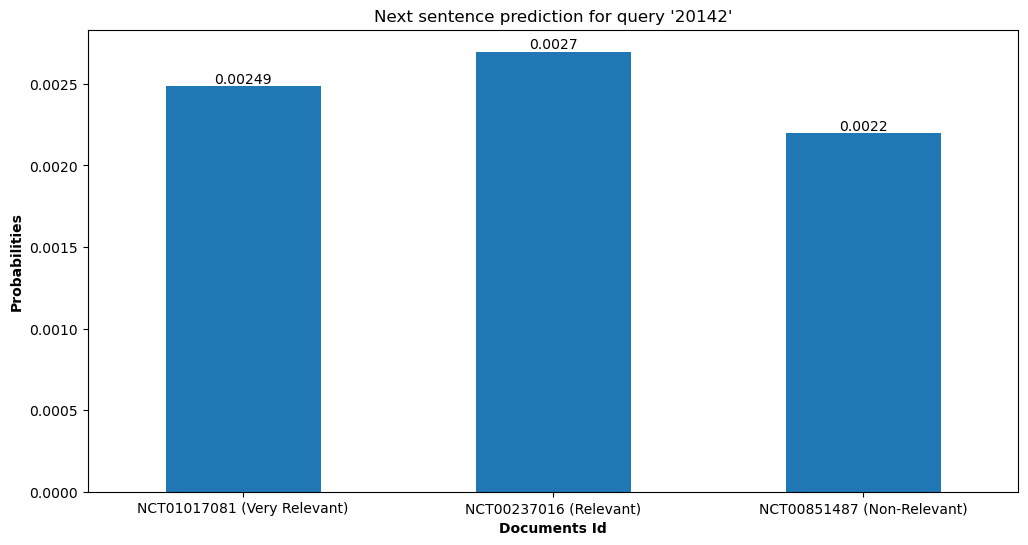

In [9]:
df = pd.DataFrame(
    list(zip( [
        f'{very_relevant_doc} (Very Relevant)',
        f'{relevant_doc} (Relevant)',
        f'{non_relevant_doc} (Non-Relevant)',
     ], scores)),
    columns=['doc-id', 'score']
)

df.set_index('doc-id', inplace=True)
ax = df.plot(
    kind='bar',
    figsize=(12, 6),
    legend=False
)
for cnt in ax.containers:
    ax.bar_label(cnt, labels=[f"{round(v, 5)}" for v in cnt.datavalues])

plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel('Documents Id', fontweight='bold')
plt.ylabel('Probabilities', fontweight='bold')
plt.title(f'Next sentence prediction for query \'{query_id}\'')
plt.savefig('next-sentece-prediction.pdf')

## Layer embeddings visualization

In [10]:
query = queries['20143']
str_tokens = tokenizer.tokenize(query)
str_tokens

['a',
 '58',
 '-',
 'year',
 '-',
 'old',
 'non',
 '##smo',
 '##ker',
 'white',
 'female',
 'with',
 'mild',
 'ex',
 '##ert',
 '##ional',
 'd',
 '##ys',
 '##p',
 '##nea',
 'and',
 'occasional',
 'cough',
 'is',
 'found',
 'to',
 'have',
 'a',
 'left',
 'lung',
 'mass',
 'on',
 'chest',
 'x',
 '-',
 'ray',
 '.',
 'she',
 'is',
 'otherwise',
 'as',
 '##ym',
 '##pt',
 '##oma',
 '##tic',
 '.',
 'a',
 'ne',
 '##uro',
 '##logic',
 'examination',
 'is',
 'un',
 '##rem',
 '##ark',
 '##able',
 ',',
 'but',
 'a',
 'ct',
 'scan',
 'of',
 'the',
 'head',
 'shows',
 'a',
 'solitary',
 'mass',
 'in',
 'the',
 'right',
 'frontal',
 'lobe',
 '.']

In [11]:
rel_doc = docs_desc['NCT00124761'] # full text of the document c:

inputs = tokenizer.encode_plus(
    query, rel_doc, return_tensors='pt',
    add_special_tokens=True, max_length = 512, truncation = True
)


inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs)
    input_embeddings  = model.embeddings.word_embeddings(inputs['input_ids'])

    # first_layer_embeddings = model.embeddings(**inputs)
# outputs.keys(



In [12]:
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)

def get_word_vector(inputs, outputs, idx, layer):
    """Get a word vector by averaging the embeddings of
       all word occurrences of that word in the input"""

    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(inputs.word_ids()) == idx)
    word_tokens_output = outputs.hidden_states[layer][0][token_ids_word]

    return word_tokens_output.mean(dim=0)


def get_input_words(inputs, input_embeddings, word):
    word_index = inputs['input_ids'][0].tolist().index(
        tokenizer.encode(word)[1]
    )
    # Extract the embedding of the word 'Hi' from the model's embedding layer
    return input_embeddings[0, word_index, :]

In [13]:
import random

words = ld.load(
    'chosen-words',
    lambda: random.sample(query.split(' '), 10),
)

words
# inputs = tokenizer.encode_plus(query, very_relevant_doc, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

# print('Inputs: ' + str(inputs.keys()))
# print('Inputs[input_ids] len(' + str(len(inputs['input_ids'])) + ')')
# print('Inputs[input_ids][0] len(' + str(len(inputs['input_ids'][0])) + '): ' + str(inputs['input_ids'][0])[0:30] + '...')

# print('Decoding: ' + tokenizer.decode(inputs['input_ids'][0]))

['cough',
 'is',
 'occasional',
 'mass',
 'right',
 'frontal',
 'unremarkable,',
 'on',
 'head',
 'lung']

In [216]:
def copy_from_gpu(values):
  return np.array(list(map(
      lambda tensor: tensor.detach().cpu().numpy(), values
  )))

sentence_a = tokenizer.decode(inputs["input_ids"][0].tolist()).replace("[CLS] ", '').replace(" [SEP]", '')

def get_embeddings(words, layer):
  return  copy_from_gpu(map(
      lambda w : get_word_vector(inputs, outputs, get_word_idx(sentence_a, w), layer), words
  ))

first_layer_embeddings = get_embeddings(words, 0)
last_layer_embeddings  = get_embeddings(words, -1)

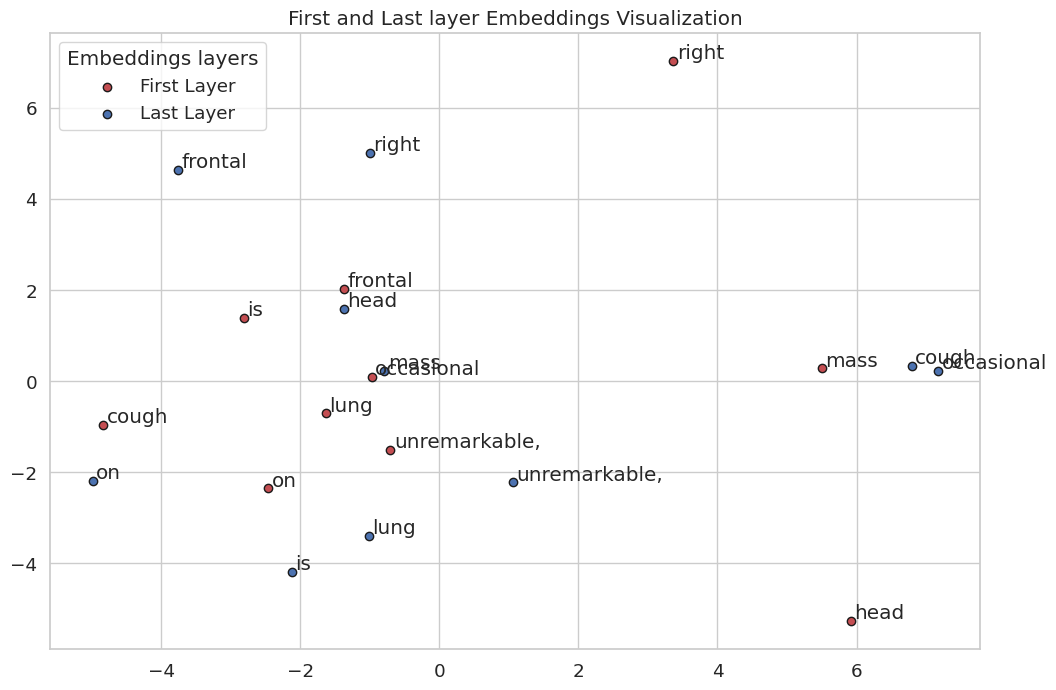

In [218]:
from sklearn.decomposition import PCA

def display_pca_scatterplot(words, first_layer, last_layer):
    # word_vectors = np.array([model[w] for w in words])
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    plt.figure(figsize=(12,8))
    for color, word_vectors, label in zip(['r', 'b'], [first_layer, last_layer], ['First Layer', 'Last Layer']):
      twodim = PCA().fit_transform(word_vectors)[:,:2]
      plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=color, label=label)
      for word, (x,y) in zip(words, twodim):
          plt.text(x+0.05, y+0.05, word)

    plt.title('First and Last layer Embeddings Visualization')
    plt.legend(title='Embeddings layers', loc='upper left')
    # plt.savefig("scatter-similarity.pdf")



# pp.pprint(first_layer_embbeddings)
# first_layer_embbeddings
display_pca_scatterplot(
    words,
    first_layer_embeddings,
    last_layer_embeddings
)


# with torch.no_grad():
#     outputs = crossEncoderModel(**inputs)

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# use a function that receives two arrays of embeddings and computes the similarity
def compute_similarity(embeddings_1, embeddings_2):
    # normalize embeddings
    embeddings_1 = embeddings_1 / np.linalg.norm(embeddings_1, axis=1, keepdims=True)
    embeddings_2 = embeddings_2 / np.linalg.norm(embeddings_2, axis=1, keepdims=True)
    # compute cosine similarity and return
    return np.matmul(embeddings_1, embeddings_2.T)

def plot_heat_map(words, similarities):

    # Set up Matplotlib and Seaborn settings for a clear heatmap

    plt.figure(figsize=(20, 16))
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")
    for i, aux in enumerate(similarities):

        index = i # Calculate the index for the current subplot
        plt.subplot(len(similarities), 1, index + 1)  # Subplot index starts from 1

        title = aux['title']
        consine_similarity = aux['similarity-matrix']

        plt.title(title)
        sns.heatmap(consine_similarity, cmap="viridis", annot=True, fmt=".2f", linewidths=.5)

        # Set custom labels for x-axis and y-axis
        plt.xticks(np.arange(len(words)) + 0.5, words, rotation=45)
        plt.yticks(np.arange(len(words)) + 0.5, words, rotation=0)

    # Show the plot
    plt.tight_layout()
    plt.savefig("heat-map.pdf")
    plt.show()

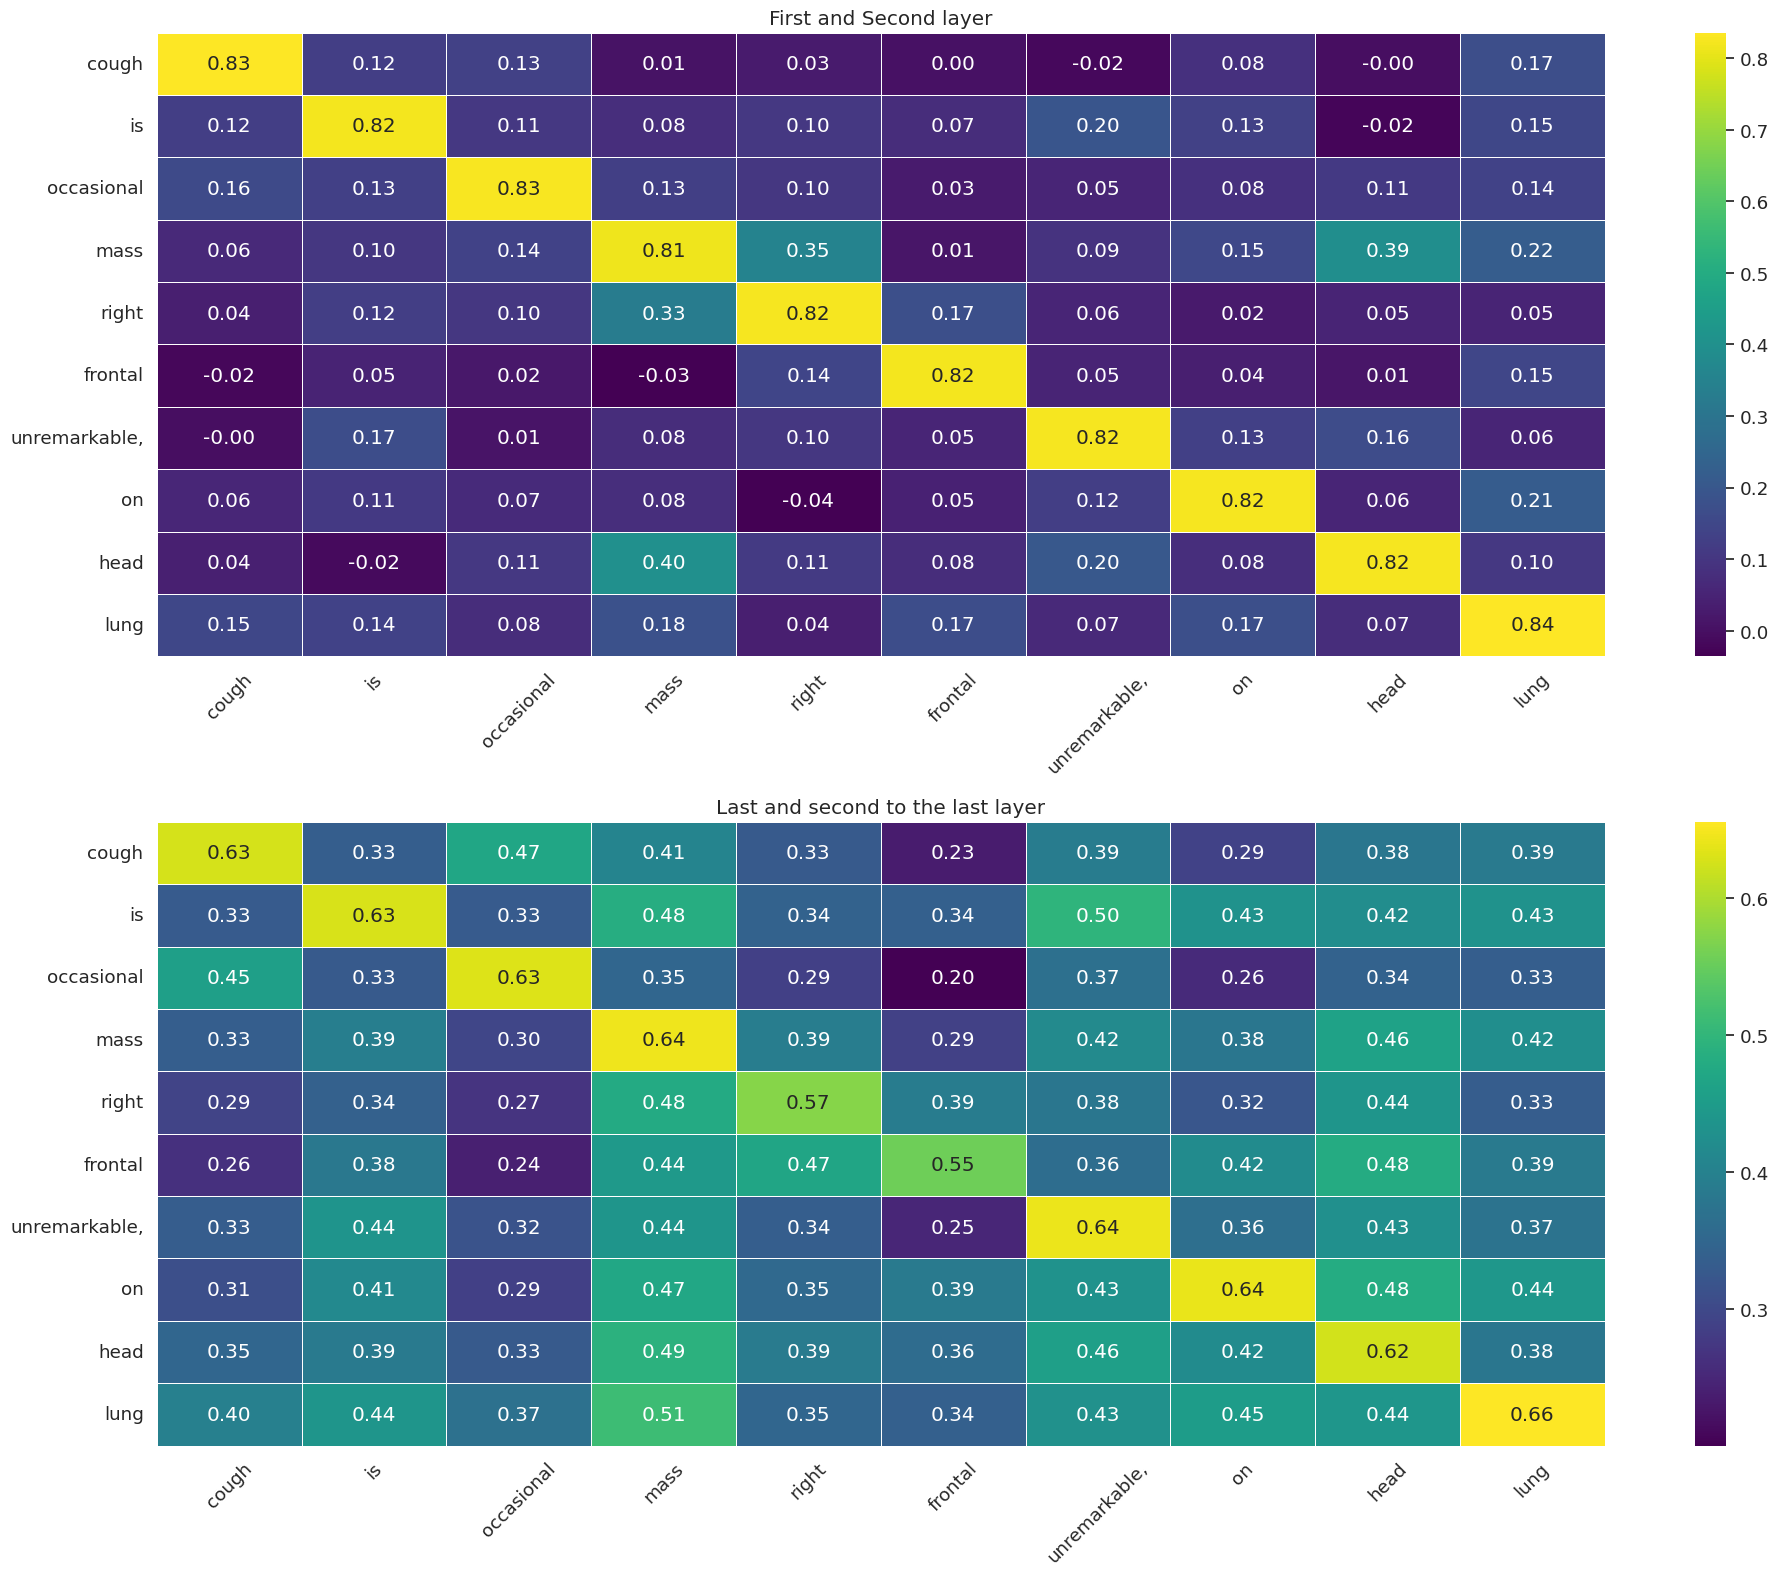

In [225]:
plot_heat_map(
    words,  [
        {
            'title': "First and Second layer",
            'similarity-matrix':  compute_similarity(first_layer_embeddings, get_embeddings(words, 1))
        },

        {
            'title': "Last and second to the last layer",
            'similarity-matrix':  compute_similarity(last_layer_embeddings, get_embeddings(words, -2))
        }
    ]
)


In [12]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

## Attention Visualization 

In [13]:
sentence_a = "Did you enjoy IR?"
sentence_b = "Yes I did, but on the last minute things took and unexpected turn."
inputs = tokenizer.encode_plus(
    sentence_a, sentence_b, return_tensors='pt',
    add_special_tokens=True, max_length = 512, truncation = True
)

inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs)

input_id_list = inputs['input_ids'][0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)


In [14]:
call_html()
model_view(outputs['attentions'], tokens)

<IPython.core.display.Javascript object>

In [15]:
call_html()
head_view(outputs['attentions'], tokens)

<IPython.core.display.Javascript object>